In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as tfs
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import pandas as pd

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize(0.5, 0.5)
])

root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, pin_memory=True)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool1(x)
        x = self.activation(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model_cls = LeNet().to(device)

criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = torch.optim.Adam(model_cls.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
def train(model, criterion, optimizer, loaders, epochs=10, device="cpu"):
    accuracy = {"train": [], "valid": []}
    for epoch in range(epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)

                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = len(preds)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)

In [ ]:
train(model_cls, criterion_cls, optimizer_cls, loaders, epochs=10, device=device)

In [ ]:
torch.save(model_cls.state_dict(), "model_cls.pth")

In [4]:
model_cls = LeNet().to(device)
model_cls.load_state_dict(torch.load("model_cls.pth"))

<All keys matched successfully>

In [ ]:
plt.imshow(train_dataset[0][0][0], cmap="gray")

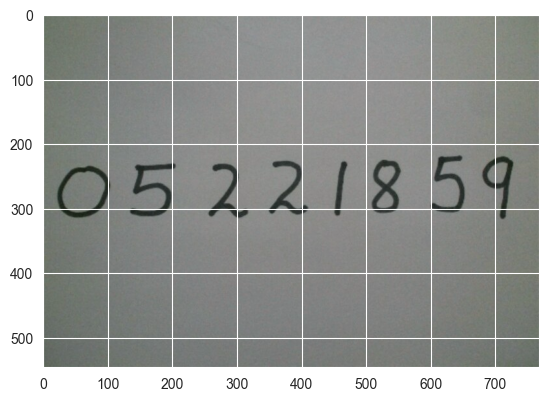

In [5]:
img = cv2.imread("digit-reco-1-in.jpg")
plt.imshow(img, cmap="gray")

In [6]:
def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (7, 7), 0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    img = cv2.bitwise_not(img, img)
    kernel = np.ones((5, 5), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    return img

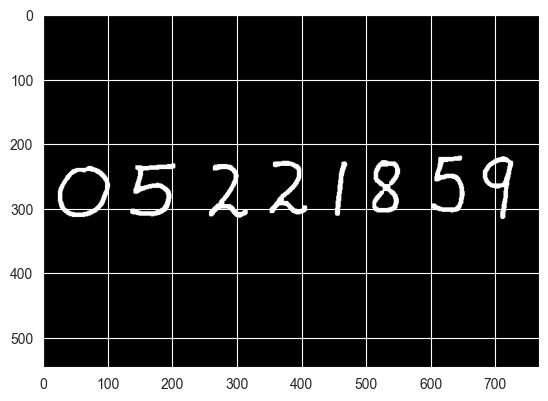

In [7]:
img = preprocess(img)
plt.imshow(img, cmap="gray")

In [8]:
def get_bounding_boxes(img):
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, w, h))
    
    bounding_boxes = sorted(bounding_boxes, key=lambda x: x[0])
    return bounding_boxes

def draw_bounding_boxes(img, bounding_boxes):
    for x, y, w, h in bounding_boxes:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    return img

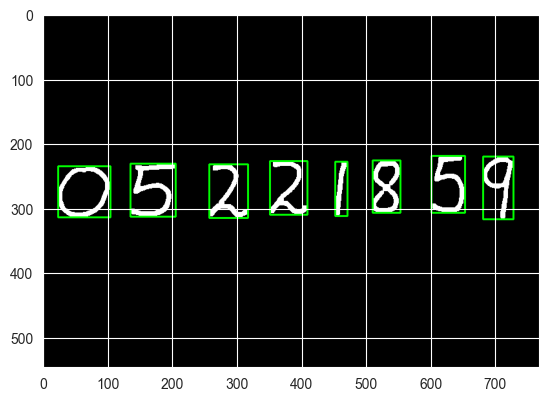

In [9]:
bounding_boxes = get_bounding_boxes(img)
img_with_bbox = img.copy()
img_with_bbox = cv2.cvtColor(img_with_bbox, cv2.COLOR_GRAY2BGR)
img_with_bbox = draw_bounding_boxes(img_with_bbox, bounding_boxes)
plt.imshow(img_with_bbox)

In [10]:
def extract_digits(img, bounding_boxes):
    digits = []
    for x, y, w, h in bounding_boxes:
        digit = img[y:y+h, x:x+w]
        if digit.shape[0] > digit.shape[1]:
            padding = (digit.shape[0] - digit.shape[1]) // 2
            digit = np.pad(digit, ((0, 0), (padding, padding)), "constant", constant_values=0)
        elif digit.shape[0] < digit.shape[1]:
            padding = (digit.shape[1] - digit.shape[0]) // 2
            digit = np.pad(digit, ((padding, padding), (0, 0)), "constant", constant_values=0)
        digit = np.pad(digit, 10, "constant", constant_values=0)
        digit = cv2.resize(digit, (28, 28))
        kernel = np.ones((2, 2), np.uint8)
        digit = cv2.dilate(digit, kernel, iterations=1)
        digit = digit / 255
        digits.append(digit)
    return digits

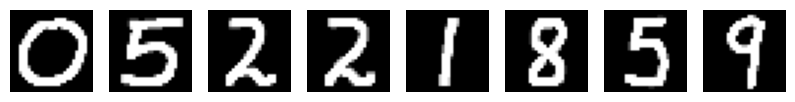

In [11]:
digits = extract_digits(img, bounding_boxes)
plt.figure(figsize=(10, 10))
for i, digit in enumerate(digits):
    plt.subplot(1, len(digits), i+1)
    plt.axis("off")
    plt.imshow(digit, cmap="gray")

In [12]:
# Define a function to predict digits
def predict_digits(digits, model):
    outp = model(digits)
    preds = outp.argmax(-1)
    return preds

In [13]:
digits_tensor = torch.tensor(digits).unsqueeze(1).float().to(device)
preds = predict_digits(digits_tensor, model_cls)
print(preds)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_52400\252027670.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:204.)
  digits_tensor = torch.tensor(digits).unsqueeze(1).float().to(device)


tensor([0, 5, 2, 2, 1, 8, 5, 9], device='cuda:0')


In [14]:
def draw_preds(img, bounding_boxes, preds):
    for (x, y, w, h), pred in zip(bounding_boxes, preds):
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(img, str(pred.item()), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
    return img

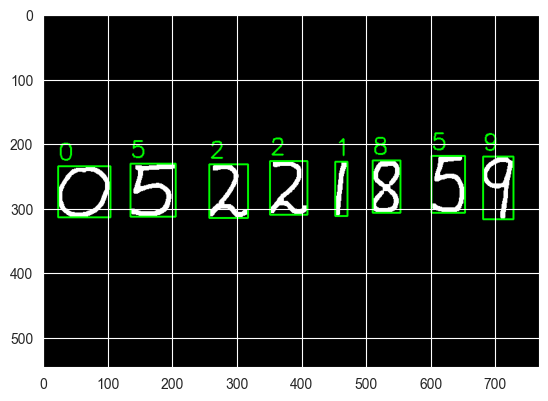

In [15]:
img_with_preds = img.copy()
img_with_preds = cv2.cvtColor(img_with_preds, cv2.COLOR_GRAY2BGR)
img_with_preds = draw_preds(img_with_preds, bounding_boxes, preds)
plt.imshow(img_with_preds)

In [16]:
def regonize_digits(img, model):
    img = preprocess(img)
    bounding_boxes = get_bounding_boxes(img)
    digits = extract_digits(img, bounding_boxes)
    digits_tensor = torch.tensor(digits).unsqueeze(1).float().to(device)
    preds = predict_digits(digits_tensor, model)
    img_with_preds = img.copy()
    img_with_preds = cv2.cvtColor(img_with_preds, cv2.COLOR_GRAY2BGR)
    img_with_preds = draw_preds(img_with_preds, bounding_boxes, preds)
    full_number = "".join([str(pred.item()) for pred in preds])
    return full_number, preds, img_with_preds, bounding_boxes, digits

(-0.5, 1007.5, 629.5, -0.5)

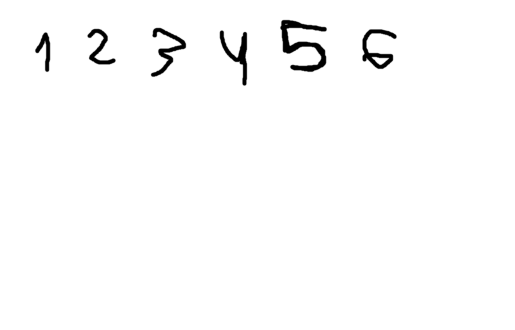

In [17]:
test = cv2.imread("test.png")
plt.imshow(test)
plt.axis("off")

483456


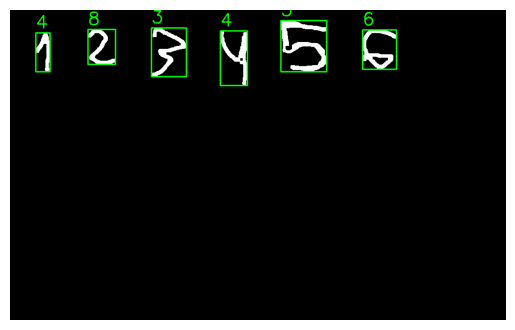

In [18]:
full_number, preds, img_with_preds, bounding_boxes, digits = regonize_digits(test, model_cls)
print(full_number)
plt.imshow(img_with_preds)
plt.axis("off")
pass

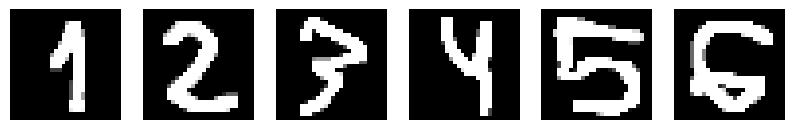

In [19]:
plt.figure(figsize=(10, 10))
for i, digit in enumerate(digits):
    plt.subplot(1, len(digits), i+1)
    plt.axis("off")
    plt.imshow(digit, cmap="gray")

(-0.5, 1007.5, 629.5, -0.5)

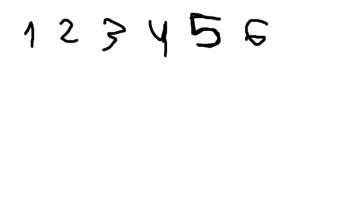

In [174]:
test = cv2.imread("test.png")
plt.imshow(test)
plt.axis("off")

483456


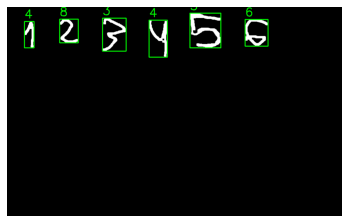

In [177]:
full_number, preds, img_with_preds, bounding_boxes, digits = regonize_digits(test, model_cls)
print(full_number)
plt.imshow(img_with_preds)
plt.axis("off")
pass

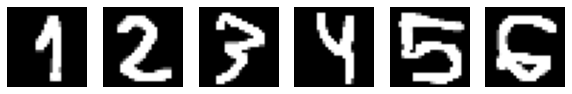

In [176]:
plt.figure(figsize=(10, 10))
for i, digit in enumerate(digits):
    plt.subplot(1, len(digits), i+1)
    plt.axis("off")
    plt.imshow(digit, cmap="gray")

In [142]:
# Define a function to return all bounding boxes of digits
def get_bounding_boxes(img):
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, w, h))
    
    # Sort bounding boxes from left to right
    bounding_boxes = sorted(bounding_boxes, key=lambda x: x[0])
    return bounding_boxes

def draw_bounding_boxes(img, bounding_boxes):
    for x, y, w, h in bounding_boxes:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    return img

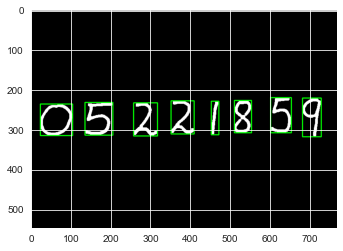

In [143]:
bounding_boxes = get_bounding_boxes(img)
img_with_bbox = img.copy()
img_with_bbox = cv2.cvtColor(img_with_bbox, cv2.COLOR_GRAY2BGR)
img_with_bbox = draw_bounding_boxes(img_with_bbox, bounding_boxes)
plt.imshow(img_with_bbox)

In [144]:
# Define a function to extract digits from image with padding
def extract_digits(img, bounding_boxes):
    digits = []
    for x, y, w, h in bounding_boxes:
        digit = img[y:y+h, x:x+w]
        if digit.shape[0] > digit.shape[1]:
            padding = (digit.shape[0] - digit.shape[1]) // 2
            digit = np.pad(digit, ((0, 0), (padding, padding)), "constant", constant_values=0)
        elif digit.shape[0] < digit.shape[1]:
            padding = (digit.shape[1] - digit.shape[0]) // 2
            digit = np.pad(digit, ((padding, padding), (0, 0)), "constant", constant_values=0)
        # Add additional padding
        digit = np.pad(digit, 10, "constant", constant_values=0)
        digit = cv2.resize(digit, (28, 28))
        # dialute image
        kernel = np.ones((2, 2), np.uint8)
        digit = cv2.dilate(digit, kernel, iterations=1)
        digit = digit / 255
        digits.append(digit)
    return digits

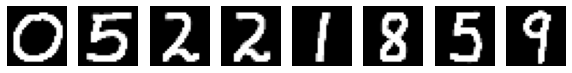

In [145]:
digits = extract_digits(img, bounding_boxes)
plt.figure(figsize=(10, 10))
for i, digit in enumerate(digits):
    plt.subplot(1, len(digits), i+1)
    plt.axis("off")
    plt.imshow(digit, cmap="gray")

In [146]:
# Define a function to predict digits
def predict_digits(digits, model):
    outp = model(digits)
    preds = outp.argmax(-1)
    return preds

In [147]:
digits_tensor = torch.tensor(digits).unsqueeze(1).float().to(device)
preds = predict_digits(digits_tensor, model_cls)
print(preds)

tensor([0, 5, 2, 2, 1, 8, 5, 9], device='cuda:0')


In [150]:
# Define a function to draw predicted digits on image
def draw_preds(img, bounding_boxes, preds):
    for (x, y, w, h), pred in zip(bounding_boxes, preds):
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(img, str(pred.item()), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
    return img

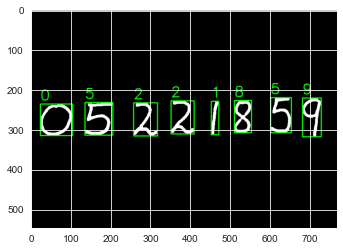

In [151]:
img_with_preds = img.copy()
img_with_preds = cv2.cvtColor(img_with_preds, cv2.COLOR_GRAY2BGR)
img_with_preds = draw_preds(img_with_preds, bounding_boxes, preds)
plt.imshow(img_with_preds)

In [152]:
# Full pipeline
def regonize_digits(img, model):
    img = preprocess(img)
    bounding_boxes = get_bounding_boxes(img)
    digits = extract_digits(img, bounding_boxes)
    digits_tensor = torch.tensor(digits).unsqueeze(1).float().to(device)
    preds = predict_digits(digits_tensor, model)
    img_with_preds = img.copy()
    img_with_preds = cv2.cvtColor(img_with_preds, cv2.COLOR_GRAY2BGR)
    img_with_preds = draw_preds(img_with_preds, bounding_boxes, preds)
    full_number = "".join([str(pred.item()) for pred in preds])
    return full_number, preds, img_with_preds, bounding_boxes, digits

(-0.5, 1007.5, 629.5, -0.5)

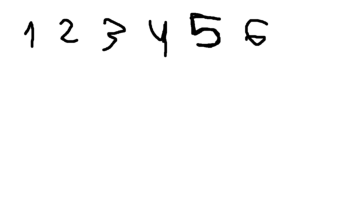

In [154]:
test = cv2.imread("test.png")
plt.imshow(test)
plt.axis("off")

483456


(-0.5, 1007.5, 629.5, -0.5)

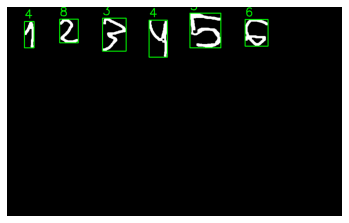

In [157]:
full_number, preds, img_with_preds, bounding_boxes, digits = regonize_digits(test, model_cls)
print(full_number)
plt.imshow(img_with_preds)
plt.axis("off")

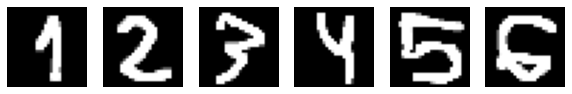

In [158]:
plt.figure(figsize=(10, 10))
for i, digit in enumerate(digits):
    plt.subplot(1, len(digits), i+1)
    plt.axis("off")
    plt.imshow(digit, cmap="gray")